## Problem 1: Optical Flow

In this problem, the multi-resolution Lucas-Kanade algorithm for estimating optical flow will be implemented, and the data needed for this problem can be found in the folder 'optical_flow_images'.

An example optical flow output is shown below - this is not a solution, just an example output.

![title](optical_flow_images/sample_optical_flow_output.png)

### Part 1: Multi-resolution Lucas-Kanade implementation 

Implement the Lucas-Kanade method for estimating optical flow. The function 'LucasKanadeMultiScale' needs to be completed. You can implement 'upsample_flow' and 'OpticalFlowRefine' as 2 building blocks in order to complete this.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import pyramid_gaussian
from scipy.signal import convolve
from scipy.interpolate import interp2d
%matplotlib inline
from tqdm import tqdm_notebook, tqdm

def grayscale(img):
    '''
    Converts RGB image to Grayscale
    '''
    gray=np.zeros((img.shape[0],img.shape[1]))
    gray=img[:,:,0]*0.2989+img[:,:,1]*0.5870+img[:,:,2]*0.1140
    return gray

def plot_optical_flow(img,U,V,titleStr):
    '''
    Plots optical flow given U,V and one of the images
    '''
    
    # Change t if required, affects the number of arrows
    # t should be between 1 and min(U.shape[0],U.shape[1])
    t=10 
    
    # Subsample U and V to get visually pleasing output
    U1 = U[::t,::t]
    V1 = V[::t,::t]
    
    # Create meshgrid of subsampled coordinates
    r, c = img.shape[0],img.shape[1]
    cols,rows = np.meshgrid(np.linspace(0,c-1,c), np.linspace(0,r-1,r))
    cols = cols[::t,::t]
    rows = rows[::t,::t]
    
    # Plot optical flow
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.quiver(cols,rows,U1,V1)
    plt.title(titleStr)
    plt.show()
    
images=[]
for i in range(1,5):
    images.append(plt.imread('optical_flow_images/im'+str(i)+'.png')[:,:288,:])
# each image after converting to gray scale is of size -> 400x288

In [2]:
# you can use interpolate from scipy
# You can implement 'upsample_flow' and 'OpticalFlowRefine' 
# as 2 building blocks in order to complete this.
def upsample_flow(u_prev, v_prev):
    ''' You may implement this method to upsample optical flow from
    previous level
    u_prev, v_prev -> optical flow from prev level
    u, v -> upsampled optical flow to the current level
    '''
    assert(u_prev.shape == v_prev.shape);
    Ny, Nx = u_prev.shape;
    
    u = np.zeros((Ny*2, Nx*2));
    v = np.zeros((Ny*2, Nx*2));
        
    # Iterate and interpolate to sample points    
    for iy in range(Ny*2):
        for ix in range(Nx*2):
            
            ty1, tx1 = iy//2, ix//2;
            ty2, tx2 = ty1+1, tx1+1;
            
            # supress boundary values
            if ty2 >= Ny or tx2 >= Nx:
                continue;
            
            engine_u = interp2d([ty1,ty1,ty2,ty2],
                                [tx1,tx2,tx1,tx2],
                                [u_prev[ty1,tx1], u_prev[ty1,tx2],
                                u_prev[ty2,tx1], u_prev[ty2,tx2]]);
            engine_v = interp2d([ty1,ty1,ty2,ty2],
                                [tx1,tx2,tx1,tx2],
                                [v_prev[ty1,tx1], v_prev[ty1,tx2],
                                v_prev[ty2,tx1], v_prev[ty2,tx2]]);
            
            u[iy,ix] = engine_u(iy/2,ix/2) *2;
            v[iy,ix] = engine_v(iy/2,ix/2) *2;
    
    return u, v

In [3]:
def OpticalFlowRefine(im1,im2, window, u_prev=None, v_prev=None):
    '''
    Inputs: the two grayscale images at current level and window size
    u_prev, v_prev - previous levels optical flow
    Return u,v - optical flow at current level
    '''
    # Prase parameters
    assert(im1.shape == im2.shape);
    Ny, Nx = im1.shape;
    invalid = set();
    
    # upsample flow from previous level
    if (not u_prev is None and not v_prev is None):
        u, v = upsample_flow(u_prev, v_prev);
    else:
        u = np.zeros_like(im1);
        v = np.zeros_like(im1);
        
    # Compute Ix, Iy
    ## Observe that canvas coordinate is different from the cartesian xy-coordinate
    Iy, Ix = np.gradient(im1);
    # the direction of y is adjusted at last
    # Iy = -1 * Iy;

    # Compute It
    ## Take displacement into consideration
    It = np.zeros_like(im1);
    ## If no displacement, equivalent of computing im2-im1
    for y in range(Ny):
        for x in range(Nx):
            ## Examine if index goes out of boundary
            if y+v[y,x] < 0 or y+v[y,x] > Ny-1:
                invalid.add((y,x));
                continue;
            if x+u[y,x] < 0 or x+u[y,x] > Nx-1:
                invalid.add((y,x));
                continue;
            # Use interpolation to calculate the corresponding value in im2
            ty1, tx1 = int(y+v[y,x]), int(x+u[y,x]);
            ty2, tx2 = ty1+1, tx1+1;
            # Suppress boundary points
            if ty1 == Ny-1 or tx1 == Nx-1:
                It[y,x] = im2[ty1, tx1] - im1[y,x];
                continue;
            else:
                engine = interp2d([ty1,ty1,ty2,ty2],
                                  [tx1,tx2,tx1,tx2],
                                  [im2[ty1,tx1], im2[ty1,tx2],
                                    im2[ty2,tx1], im2[ty2,tx2]]);
                It[y,x] = engine(y+v[y,x], x+u[y,x]) - im1[y,x];
    
    # Compute parameters for each window
    Ix2 = np.square(Ix);
    Iy2 = np.square(Iy);
    Ixy = np.multiply(Ix, Iy);
    Ixt = np.multiply(Ix, It);
    Iyt = np.multiply(Iy, It);
    
    Gx2 = convolve(Ix2, np.ones((window, window)), mode='same');
    Gy2 = convolve(Iy2, np.ones((window, window)), mode='same');
    Gxy = convolve(Ixy, np.ones((window, window)), mode='same');
    Gxt = convolve(Ixt, np.ones((window, window)), mode='same');
    Gyt = convolve(Iyt, np.ones((window, window)), mode='same');
    
    for y in range(Ny):
        for x in range(Nx):
            
            if (y,x) in invalid:
                continue;
                        
            # Compute the A matrix for *each window*
            A = np.array([[Gx2[y,x], Gxy[y,x]], [Gxy[y,x], Gy2[y,x]]]);
            b = np.array([[-Gxt[y,x]], [-Gyt[y,x]]]);
            
            # Least square method
            u_p, v_p = np.linalg.lstsq(A, b, rcond=None)[0];
            u[y,x] += u_p;
            v[y,x] += v_p;
    
    return u, v

In [4]:
def LucasKanadeMultiScale(im1,im2, window, numLevels=2):
    '''
    Implement the multi-resolution Lucas kanade algorithm
    Inputs: the two grayscale images, window size and number of levels
    if numLevels = 1, then compute optical flow at only the given image level.
    Returns: u, v - the optical flow
    '''
    # You can call OpticalFlowRefine iteratively
        
    # Build pyramid (Coarse-2-fine)
    pyramid_im1 = list(pyramid_gaussian(im1, max_layer=numLevels-1, downscale=2, multichannel=False));
    pyramid_im1.reverse();
    pyramid_im2 = list(pyramid_gaussian(im2, max_layer=numLevels-1, downscale=2, multichannel=False));
    pyramid_im2.reverse();
    
    u = None;
    v = None;
    
    for i, (p1, p2) in enumerate(zip(pyramid_im1, pyramid_im2)):
        u, v = OpticalFlowRefine(p1, p2, window, u, v);
    
    return u, -1*v; # y direction adjust to plotting

### Part 2: Number of levels

Plot optical flow for the pair of images im1 and im2 for different number of levels mentioned below. Comment on the results and justify.<br>
(i) window size = 13, numLevels = 1<br>
(ii) window size = 13, numLevels = 3<br>
(iii) window size = 13, numLevels = 5<br>
So, you are expected to provide 3 outputs here<br>

Note: if numLevels = 1, then it means the optical flow is only computed at the image resolution i.e. no downsampling

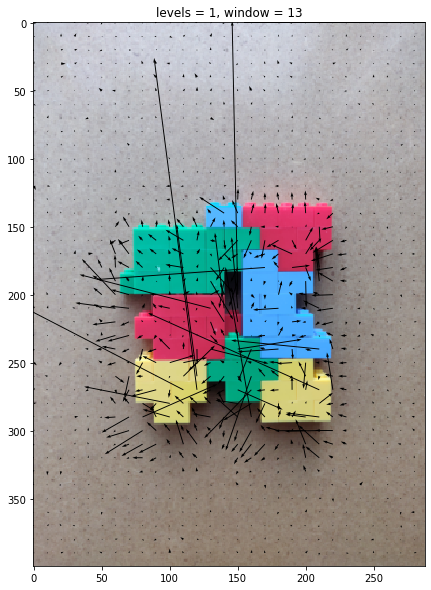

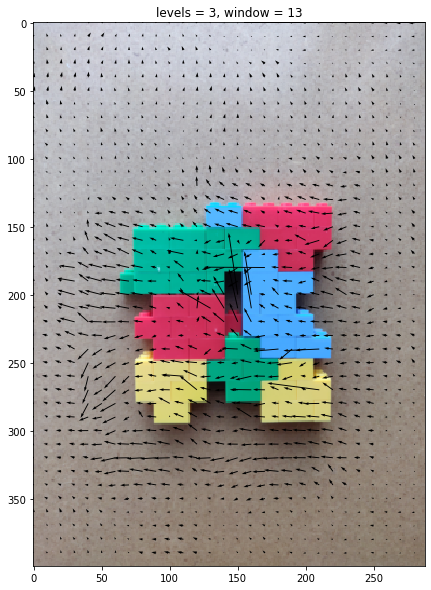

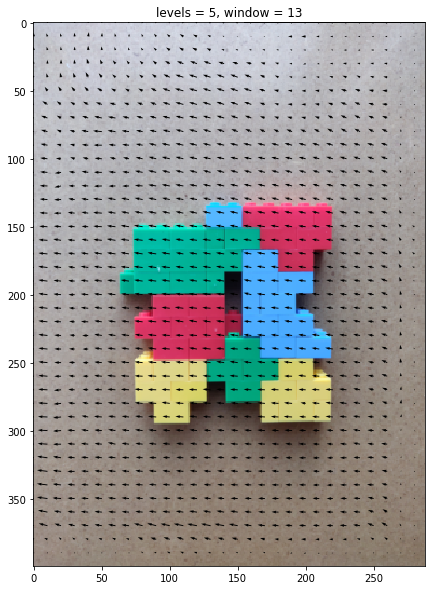

In [5]:
# Example code to generate output
window=13;
numLevels=[1,3,5];

for l in numLevels:
    
    U,V=LucasKanadeMultiScale(grayscale(images[0]),grayscale(images[1]),\
                              window,l)
    plot_optical_flow(images[0],U,V, \
                      'levels = ' + str(l) + ', window = '+str(window))

#### Your Comments on the results of Part 2:

`Results`: When we have only 1 level, we can see a lot of long arrows (noises) and irregular patterns of flow. When we have 3 levels, most of the long arrows disappear and the flow becomes regular. When we have 5 levels, the noises are gone, and all pixels have the same amount of displacement (expected the ones at the boundary, which are suppressed). This is exactly the result that we are expecting since by eyeballing the object just moved left from image 1 to image 2.

`Justification`: It is clear that as we increase the number of downsamples (iterations), we would get better results. While there are many irregular patterns due to noises at the first few steps, as we upsample and refine from the displacement of the previous step, we are doing small rectifications to our original estimates. Assume the object itself is moving in the space direction, then we should expect some flow that move through that direction, which is exactly the output when we have 5 levels.

### Part 3: Window size

Plot optical flow for the pair of images im1 and im2 for at least 3 different window sizes which leads to observable difference in the results. Comment on the effect of window size on results and justify. For this part fix the number of levels to be 3.

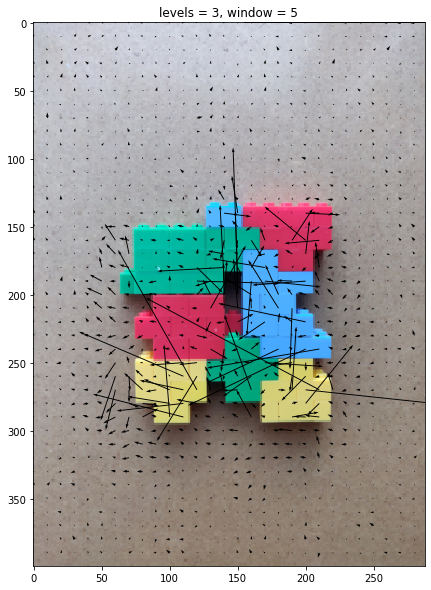

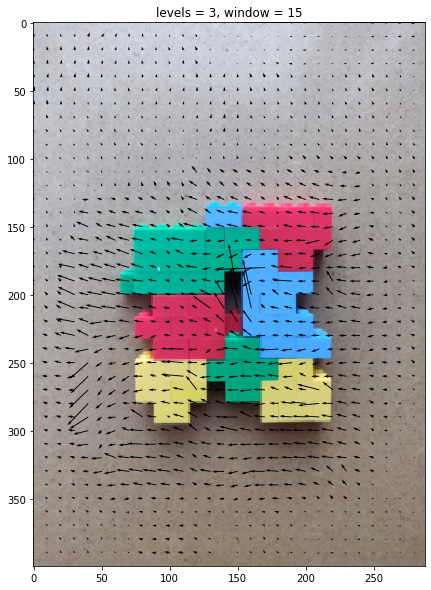

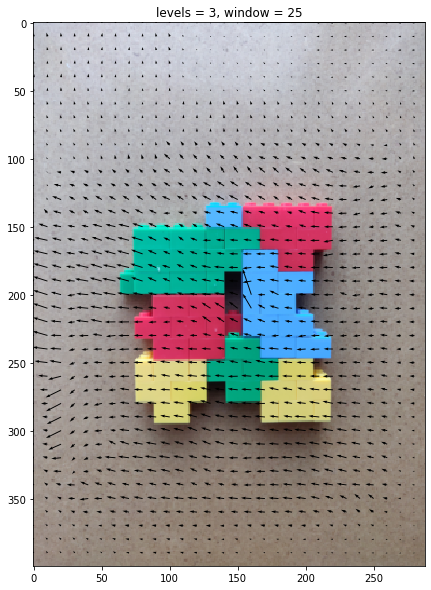

In [6]:
# Example code, change as required
numLevels=3

w1, w2, w3 = 5, 15, 25
for window in [w1, w2, w3]:
    U,V=LucasKanadeMultiScale(grayscale(images[0]),grayscale(images[1]),\
                              window,numLevels)
    plot_optical_flow(images[0],U,V, \
                      'levels = ' + str(numLevels) + ', window = '+str(window))

#### Your Comments on the results of Part 3:

`Results`: Similar to previous part, when we increase our window size, we are getting better results (less noises, long arrows, or arrow directions that do not match). For example, with a window size of 5, the arrow map shows no pattern of flow, whereas with a window size of 25, the arrow map shows that almost all arrows are moving left. (Note that a larger window also suppress the flow at corners) 

`Justification`: This is the expected result, since with a larger window size indicates that we are averaging over more neighbors, which is unlikely to yield extreme values (thus unlikely to have large magnitude arrows or arrows that are pointing in completely different directions). (However, note that a larger window could potentially require more computational tasks)

`Caveat`: the movement of `im3`, shown in the next part shows that a large window may not be favored when the object is not doing linear displacement (translation).

### Part 4: All pairs

Find optical flow for the pairs (im1,im2), (im1,im3), (im1,im4) using one good window size and number of levels. Does the optical flow result seem consistent with visual inspection? Comment on the type of motion indicated by results and visual inspection and explain why they might be consistent or inconsistent.

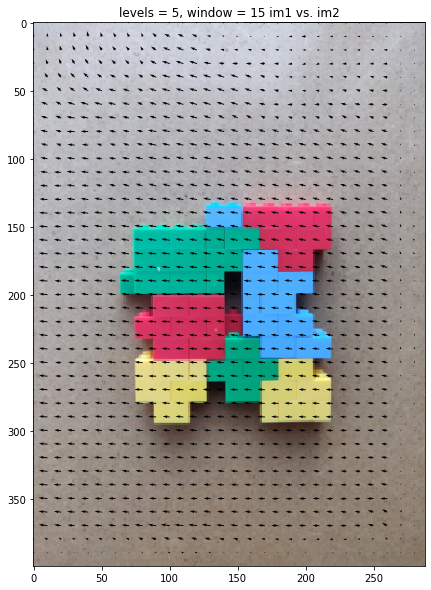

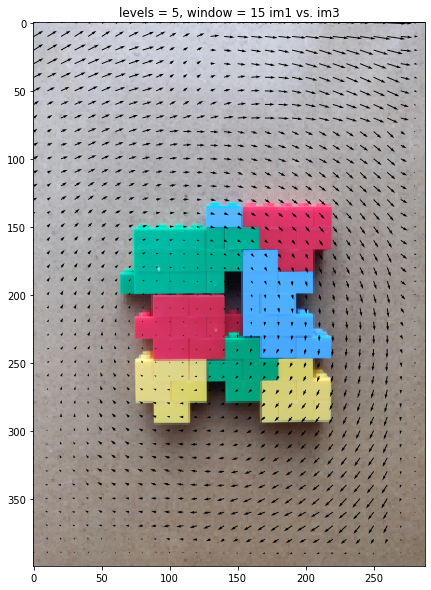

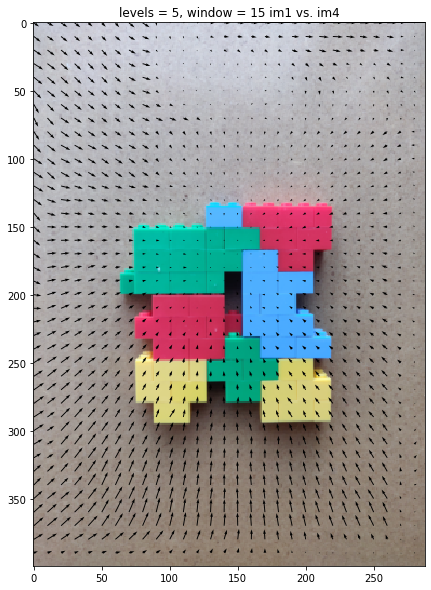

In [7]:
# Your code here
# use one fixed window and numLevels for all pairs
numLevels=5;
window=15;

for i in [1,2,3]:
    U,V=LucasKanadeMultiScale(grayscale(images[0]),grayscale(images[i]),\
                              window, numLevels)
    plot_optical_flow(images[0],U,V, \
                      'levels = ' + str(numLevels) + ', window = '+str(window) + ' im1 vs. im' + str(i+1))

#### Your Comments on the results of Part 4:

By visual inpsection, the movement in the three images are
- `im2`: left shift
- `im3`: rotation
- `im4`: change of focal length - zoom out (camera parameter)

The results of my multiscale Lucas-Kanade algorithm shows:
- `im2`: moving left
- `im3`: irregular pattern of clockwise rotation
- `im4`: shrink to the center of the image

Yes! Overall the flow estimate complies with our visual inspection. By using `im1` as the reference image:

`im1 vs im2`: By visual inspection, in `im2` the object has moved left, so we should expect a uniform distribution of arrows that points left, which is exactly the result shown above.

`im1 vs im3`: Here it is more complicated because we have no linear displacement but rotation instead. By visual inspection, the object has rotated clockwise for 10-20 degerees so each the arrow of each pixel would hardly be pointing to the same direction. However, we should expect that it shows some pattern of rotation, which is shown in the second graph above.

`im1 vs im4`: By visual inspection, there is not much displacement going on in `im4`. The change is due to the fact that the camera adjusts its focal length (zoom out). Therefore, we should expect little flow among the center of the image (since it hasn't changed) but gradual increasing magnitude towards the image center when we walk away from the center, which is exactly the one we observed in the result.

## Problem 2: Machine Learning

### Part 1: Initial setup

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable

x = torch.rand(5, 3)
print(x)

tensor([[0.1003, 0.8791, 0.8273],
        [0.2024, 0.3449, 0.1870],
        [0.1902, 0.9099, 0.2154],
        [0.5254, 0.4361, 0.3051],
        [0.9780, 0.4803, 0.3219]])


In [9]:
import os
import struct

# Change path as required
path = "mnist/"

def read(dataset = "training", datatype='images'):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels.idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels.idx1-ubyte')

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)
    
    if(datatype=='images'):
        get_data = lambda idx: img[idx]
    elif(datatype=='labels'):
        get_data = lambda idx: lbl[idx]

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_data(i)
        
trainData=np.array(list(read('training','images')))
trainLabels=np.array(list(read('training','labels')))
testData=np.array(list(read('testing','images')))
testLabels=np.array(list(read('testing','labels')))

In [10]:
# Understand the shapes of the each variable carying data
print(trainData.shape, trainLabels.shape)
print(testData.shape, testLabels.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


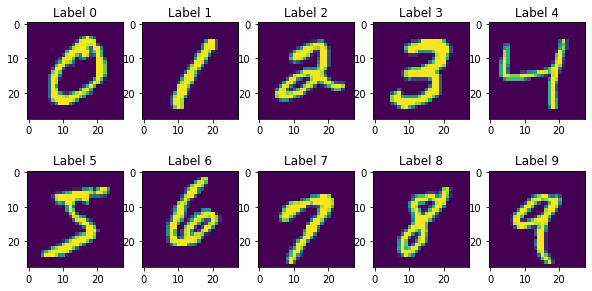

In [11]:
# display one image from each label
# """ ==========
# YOUR CODE HERE
# ========== """
fig, axs = plt.subplots(2,5,figsize=(10,5));
for i in range(10):
    index = np.where(trainLabels==i)[0][0];
    axs[i//5,i%5].set_title("Label {}".format(i));
    axs[i//5,i%5].imshow(trainData[index]);
plt.show();

Some helper functions are given below.

In [12]:
# a generator for batches of data
# yields data (batchsize, 28, 28) and labels (batchsize)
# if shuffle, it will load batches in a random order
def DataBatch(data, label, batchsize, shuffle=True):
    n = data.shape[0]
    if shuffle:
        index = np.random.permutation(n)
    else:
        index = np.arange(n)
    for i in range(int(np.ceil(n/batchsize))):
        inds = index[i*batchsize : min(n,(i+1)*batchsize)]
        yield data[inds], label[inds]

# tests the accuracy of a classifier
def test(testData, testLabels, classifier):
    batchsize=50
    correct=0.
    for data,label in DataBatch(testData,testLabels,batchsize,shuffle=False):
        prediction = classifier(data)
        correct += np.sum(prediction==label)
    return correct/testData.shape[0]*100

# a sample classifier
# given an input it outputs a random class
class RandomClassifier():
    def __init__(self, classes=10):
        self.classes=classes
    def __call__(self, x):
        return np.random.randint(self.classes, size=x.shape[0])

randomClassifier = RandomClassifier()
print('Random classifier accuracy: %f' % 
      test(testData, testLabels, randomClassifier))

Random classifier accuracy: 9.930000


### Part 2: Confusion Matrix [2 pts]
Here you will implement a function that computes the confusion matrix for a classifier.
The matrix (M) should be nxn where n is the number of classes.
Entry M[i,j] should contain the fraction of images of class i that was classified as class j.
Can you justify the accuracy given by the random classifier?

200it [00:00, 4774.58it/s]


Accuracy is 0.1062


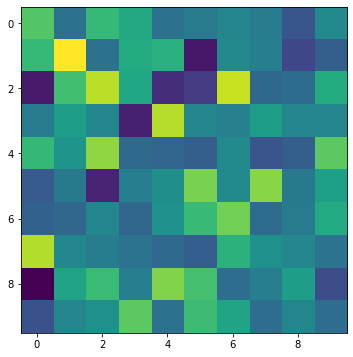

[[0.11 0.09 0.11 0.11 0.09 0.1  0.1  0.1  0.09 0.1 ]
 [0.11 0.13 0.1  0.11 0.11 0.08 0.1  0.1  0.09 0.09]
 [0.08 0.11 0.12 0.11 0.08 0.09 0.12 0.09 0.09 0.11]
 [0.1  0.1  0.1  0.08 0.12 0.1  0.1  0.1  0.1  0.1 ]
 [0.11 0.1  0.12 0.09 0.09 0.09 0.1  0.09 0.09 0.11]
 [0.09 0.1  0.08 0.1  0.1  0.12 0.1  0.12 0.1  0.1 ]
 [0.09 0.09 0.1  0.09 0.1  0.11 0.11 0.09 0.1  0.11]
 [0.12 0.1  0.1  0.1  0.09 0.09 0.11 0.1  0.1  0.1 ]
 [0.08 0.1  0.11 0.1  0.12 0.11 0.09 0.1  0.1  0.09]
 [0.09 0.1  0.1  0.11 0.1  0.11 0.11 0.09 0.1  0.09]]


In [13]:
# It would be a good idea to return the accuracy, along with the confusion 
# matrix, since both can be calculated in one iteration over test data, to 
# save time
def Confusion(testData, testLabels, classifier):
    
    correct = 0;
    size = testLabels.shape[0];
    batchsize = 50; # From test function above
    nLabels = 10;
    M = np.zeros((nLabels,nLabels))
    
    for data,label in tqdm(DataBatch(testData,testLabels,batchsize,shuffle=False)):
        pred = classifier(data);
        for i, (lab, prd) in enumerate(zip(label,pred)):
            M[lab, prd] += 1;
            correct += int(lab == prd);
    
    # Divide classification results by number of observations
    for l in range(nLabels):
        M[l] = M[l] / np.sum(M[l]);
    
    acc = correct / size;
    
    print("Accuracy is", acc);
    
    return M, acc

def VisualizeConfusion(M):
    plt.figure(figsize=(14, 6))
    plt.imshow(M)
    plt.show()
    print(np.round(M,2))

M,_ = Confusion(testData, testLabels, randomClassifier)
VisualizeConfusion(M)

#### Your Comments on the accuracy & confusion matrix of random classifier:

The accuracy of the random classifier is close to 0.1, which is exactly the probability of making the correct prediction if we are guessing randomly (1 out of 10). Notice that confusion matrix shows no pattern, and all entries in it are close to 0.1, this shows that no matter what the input label is, we are always guessing randomly, so we have equal probability of selecting 1 of the 10 possible choices, which is 0.1.

### Part 3: K-Nearest Neighbors (KNN) [4 pts]

* Here you will implement a simple knn classifier. The distance metric is Euclidean in pixel space. k refers to the number of neighbors involved in voting on the class, and should be 3. You are allowed to use sklearn.neighbors.KNeighborsClassifier.
* Display confusion matrix and accuracy for your KNN classifier trained on the entire train set. (should be ~97 %)
* After evaluating the classifier on the testset, based on the confusion matrix, mention the number that the number '7' is most often predicted to be, other than '7'.

In [14]:
from sklearn.neighbors import KNeighborsClassifier

class KNNClassifer():
    def __init__(self, k=3):
        # k is the number of neighbors involved in voting
        self._mod = KNeighborsClassifier(n_neighbors=k);
        
    def train(self, trainData, trainLabels):
        self._mod.fit(trainData.reshape(trainData.shape[0], -1), trainLabels);
        
    def __call__(self, x):
        # this method should take a batch of images
        # and return a batch of predictions
        return self._mod.predict(x.reshape(x.shape[0],-1));


# test your classifier with only the first 100 training examples (use this
# while debugging)
# note you should get ~ 65 % accuracy
knnClassiferX = KNNClassifer()
knnClassiferX.train(trainData[:100], trainLabels[:100])
print ('KNN classifier accuracy: %f'%test(testData, testLabels, knnClassiferX))

KNN classifier accuracy: 64.760000


In [15]:
# test your classifier with all the training examples (This may take a while)
knnClassifer = KNNClassifer()
knnClassifer.train(trainData, trainLabels)

200it [11:20,  3.40s/it]


Accuracy is 0.9705


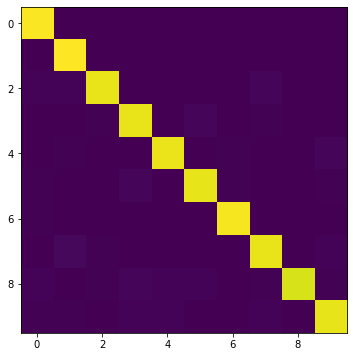

[[0.99 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.01 0.01 0.97 0.   0.   0.   0.   0.01 0.   0.  ]
 [0.   0.   0.   0.97 0.   0.01 0.   0.01 0.   0.  ]
 [0.   0.01 0.   0.   0.97 0.   0.   0.   0.   0.02]
 [0.01 0.   0.   0.01 0.   0.96 0.01 0.   0.   0.  ]
 [0.01 0.   0.   0.   0.   0.   0.99 0.   0.   0.  ]
 [0.   0.02 0.   0.   0.   0.   0.   0.96 0.   0.01]
 [0.01 0.   0.   0.02 0.01 0.01 0.   0.   0.94 0.  ]
 [0.   0.   0.   0.01 0.01 0.   0.   0.01 0.   0.96]]


In [16]:
# display confusion matrix for your KNN classifier with all the training examples
# (This may take a while)
M,_ = Confusion(testData, testLabels, knnClassifer);
VisualizeConfusion(M);

#### Answer


The number '7' is most often predicted to be '1', other than '7'.

### Part 4: Principal Component Analysis (PCA) K-Nearest Neighbors (KNN)
Here you will implement a simple KNN classifer in PCA space (for k=3 and 25 principal components).
You should implement PCA yourself using svd (you may not use sklearn.decomposition.PCA
or any other package that directly implements PCA transformations

Is the testing time for PCA KNN classifier more or less than that for KNN classifier? Comment on why it differs if it does.

In [17]:
class PCAKNNClassifer():
    def __init__(self, components=25, k=3):
        # components = number of principal components
        # k is the number of neighbors involved in voting
        self._mod = KNeighborsClassifier(n_neighbors=k);
        self._components = components;
        
    def train(self, trainData, trainLabels):
        # convert to 0-1
        train = trainData.reshape((trainData.shape[0], -1)).astype(float);
        # subtract from mean before projection
        self.mean = np.mean(train);
        train -= self.mean;
        # Compute covariance matrix and usd SVD
        cov_train = np.cov(train.T);
        U, S, V_T = np.linalg.svd(cov_train);
        V = V_T.T;
        # Calculate principle components
        self._PC = V[:,:self._components];
        self._mod.fit(train @ self._PC, trainLabels);

        
    def __call__(self, x):
        # this method should take a batch of images
        # and return a batch of predictions
        x = x.reshape(x.shape[0],-1).astype(float);
        x -= self.mean;
        return self._mod.predict(x @ self._PC);


# test your classifier with only the first 100 training examples (use this
# while debugging)
pcaknnClassiferX = PCAKNNClassifer()
pcaknnClassiferX.train(trainData[:100], trainLabels[:100])
print ('KNN classifier accuracy: %f'%test(testData, testLabels, pcaknnClassiferX))

KNN classifier accuracy: 66.160000


In [18]:
# test your classifier with all the training examples
pcaknnClassifer = PCAKNNClassifer()
pcaknnClassifer.train(trainData, trainLabels)

200it [00:14, 13.44it/s]


Accuracy is 0.9731


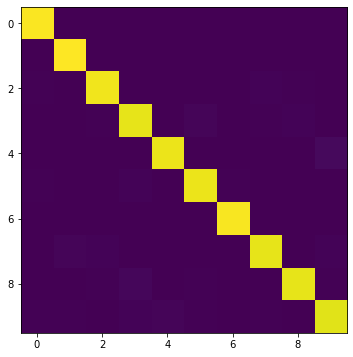

[[0.99 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.98 0.   0.   0.   0.   0.01 0.   0.  ]
 [0.   0.   0.   0.96 0.   0.01 0.   0.01 0.01 0.  ]
 [0.   0.   0.   0.   0.97 0.   0.   0.   0.   0.03]
 [0.01 0.   0.   0.01 0.   0.97 0.01 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.99 0.   0.   0.  ]
 [0.   0.02 0.01 0.   0.   0.   0.   0.96 0.   0.01]
 [0.   0.   0.   0.02 0.   0.01 0.   0.   0.96 0.  ]
 [0.   0.01 0.   0.01 0.01 0.   0.   0.   0.   0.95]]


In [19]:
# display confusion matrix for your PCA KNN classifier with all the training examples
M,_ = Confusion(testData, testLabels, pcaknnClassifer);
VisualizeConfusion(M);

#### Comments:

The training time is much less than the KNN classifier. This is an expected result since the running time of KNN is linear to the number of dimensions, thus if we reduce the number of dimensions, the running time would be drop.

## Problem 3: Deep learning
Below is some helper code to train your deep networks.

### Part 1:  Training with PyTorch
Below is some helper code to train your deep networks. 
Complete the train function for DNN below. You should write down the training operations in this function. That means, for a batch of data you have to initialize the gradients, forward propagate the data, compute error, do back propagation and finally update the parameters. This function will be used in the following questions with different networks.
You can look at https://pytorch.org/tutorials/beginner/pytorch_with_examples.html for reference.

In [20]:
# base class for your deep neural networks. It implements the training loop (train_net).
# You will need to implement the "__init__()" function to define the networks
# structures and "forward()", to propagate your data, in the following problems.

import torch.nn.init
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from tqdm import tqdm
from scipy.stats import truncnorm

# helper function to get weight variable
def weight_variable(shape):
    initial = torch.Tensor(truncnorm.rvs(-1/0.01, 1/0.01, scale=0.01, size=shape))
    return Parameter(initial, requires_grad=True)

# helper function to get bias variable
def bias_variable(shape):
    initial = torch.Tensor(np.ones(shape)*0.1)
    return Parameter(initial, requires_grad=True)

In [21]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        pass
    
    def forward(self, x):
        raise NotImplementedError;
    
    def train_net(self, trainData, trainLabels, epochs=1, batchSize=50):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr = 3e-4)
        
        for epoch in range(epochs):
            self.train()  # set netowrk in training mode
            for i, (data,labels) in enumerate(DataBatch(trainData, trainLabels, batchSize, shuffle=True)):
                data = Variable(torch.FloatTensor(data))
                labels = Variable(torch.LongTensor(labels))
                
                # YOUR CODE HERE------------------------------------------------
                # Train the model using the optimizer and the batch data
                
                ### Forward pass
                y_pred = self.forward(data);
                
                ### Compute error
                loss = criterion(y_pred, labels);
                
                ### Do back propagation
                optimizer.zero_grad();
                loss.backward();
                
                ### Update the weights
                optimizer.step();
                #------------------------------------------------------------------
                #-----End of your code, don't change anything else here------------
                
            self.eval()  # set network in evaluation mode
            print ('Epoch:%d Accuracy: %f'%(epoch+1, test(testData, testLabels, self))) 
    
    def __call__(self, x):
        inputs = Variable(torch.FloatTensor(x))
        prediction = self.forward(inputs)
        return np.argmax(prediction.data.cpu().numpy(), 1)

In [22]:
# example linear classifier - input connected to output
# you can take this as an example to learn how to extend DNN class
class LinearClassifier(DNN):
    def __init__(self, in_features=28*28, classes=10):
        super(LinearClassifier, self).__init__()
        # in_features=28*28
        self.weight1 = weight_variable((classes, in_features))
        self.bias1 = bias_variable((classes))
    
    def forward(self, x):
        # linear operation
        y_pred = torch.addmm(self.bias1, x.view(list(x.size())[0], -1), self.weight1.t())
        return y_pred
    
    def get_weight(self):
        return self.weight1;
    
trainData=np.array(list(read('training','images')))
trainData=np.float32(np.expand_dims(trainData,-1))/255
trainData=trainData.transpose((0,3,1,2))
trainLabels=np.int32(np.array(list(read('training','labels'))))

testData=np.array(list(read('testing','images')))
testData=np.float32(np.expand_dims(testData,-1))/255
testData=testData.transpose((0,3,1,2))
testLabels=np.int32(np.array(list(read('testing','labels'))))

In [23]:
# test the example linear classifier (note you should get around 90% accuracy
# for 10 epochs and batchsize 50)
linearClassifier = LinearClassifier()
linearClassifier.train_net(trainData, trainLabels, epochs=10)

Epoch:1 Accuracy: 89.220000
Epoch:2 Accuracy: 90.730000
Epoch:3 Accuracy: 91.260000
Epoch:4 Accuracy: 91.650000
Epoch:5 Accuracy: 91.820000
Epoch:6 Accuracy: 92.080000
Epoch:7 Accuracy: 92.110000
Epoch:8 Accuracy: 92.240000
Epoch:9 Accuracy: 92.340000
Epoch:10 Accuracy: 92.360000


200it [00:00, 1479.87it/s]


Accuracy is 0.9236


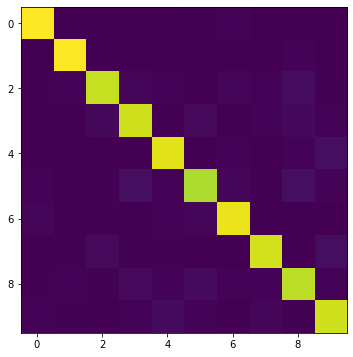

[[0.98 0.   0.   0.   0.   0.01 0.01 0.   0.   0.  ]
 [0.   0.98 0.   0.   0.   0.   0.   0.   0.01 0.  ]
 [0.01 0.01 0.89 0.02 0.01 0.   0.01 0.01 0.03 0.  ]
 [0.   0.   0.02 0.91 0.   0.02 0.   0.01 0.02 0.01]
 [0.   0.   0.   0.   0.94 0.   0.01 0.   0.01 0.04]
 [0.01 0.   0.   0.04 0.01 0.86 0.02 0.01 0.04 0.01]
 [0.01 0.   0.01 0.   0.01 0.01 0.95 0.   0.   0.  ]
 [0.   0.01 0.02 0.01 0.01 0.   0.   0.92 0.   0.04]
 [0.01 0.01 0.01 0.02 0.01 0.03 0.01 0.01 0.88 0.01]
 [0.01 0.01 0.   0.01 0.03 0.01 0.   0.02 0.   0.91]]


In [24]:
# display confusion matrix
M,_ = Confusion(testData, testLabels, linearClassifier);
VisualizeConfusion(M);

### Part 2: Single Layer Perceptron
The simple linear classifier implemented in the cell already performs quite well. Plot the filter weights corresponding to each output class (weights, not biases) as images. (Normalize weights to lie between 0 and 1 and use color maps like 'inferno' or 'plasma' for good results). Comment on what the weights look like and why that may be so.

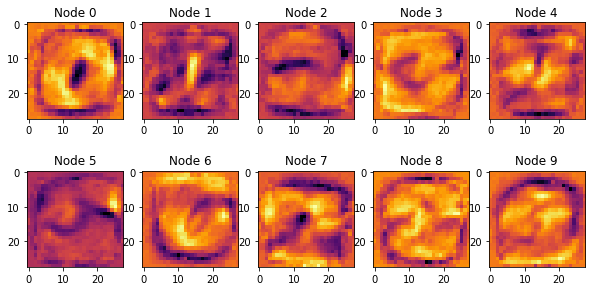

In [25]:
# Plot filter weights corresponding to each class, you may have to reshape them to make sense out of them
# linearClassifier.weight1.data will give you the first layer weights
SLP_w = linearClassifier.get_weight();
SLP_weights = SLP_w.detach().numpy();
# Plotting
fig, axs = plt.subplots(2,5,figsize=(10,5));
for i in range(10):
    # Normalize
    this_w = SLP_weights[i].reshape(28,28);
    this_w = (this_w-this_w.min())/(this_w.max()-this_w.min());
    # Show
    axs[i//5,i%5].set_title("Node {}".format(i));
    axs[i//5,i%5].imshow(this_w, cmap='inferno');
plt.show();

#### Comments on weights

The weights are indeed showing the boundary of the corresponding number. Observe that the boundary is very clear for label 0 and label 3. This is caused by the fact that the (high accuracy and) neurons have completely learned from the data and will only activate given certain pattern of data.

### Part 3: Multi Layer Perceptron (MLP)
Here you will implement an MLP. The MLP should consist of 2 layers (matrix multiplication and bias offset) that map to the following feature dimensions:

* 28x28 -> hidden (100)
* hidden -> classes

* The hidden layer should be followed with a ReLU nonlinearity. The final layer should not have a nonlinearity applied as we desire the raw logits output.
* The final output of the computation graph should be stored in self.y as that will be used in the training.

Display the confusion matrix and accuracy after training. Note: You should get ~ 97 % accuracy for 10 epochs and batch size 50.

Plot the filter weights corresponding to the mapping from the inputs to the first 10 hidden layer outputs (out of 100). Do the weights look similar to the weights plotted in the previous problem? Why or why not?

In [26]:
class MLPClassifer(DNN):
    def __init__(self, in_features=28*28, classes=10, hidden=100):
        super(MLPClassifer, self).__init__()
        self.weight1 = weight_variable((hidden, in_features));
        self.weight2 = weight_variable((classes, hidden));
        self.bias1 = bias_variable((hidden));
        self.bias2 = bias_variable((classes));
    
    def forward(self, x):
        layer1 = F.relu(torch.addmm(self.bias1, x.view(list(x.size())[0], -1), self.weight1.t()));
        layer2 = torch.addmm(self.bias2, layer1, self.weight2.t());
        self.y = layer2;
        return layer2;
    
    def get_weight_hidden(self):
        return self.weight1;

In [27]:
mlpClassifer = MLPClassifer()
mlpClassifer.train_net(trainData, trainLabels, epochs=10, batchSize=50)

Epoch:1 Accuracy: 91.330000
Epoch:2 Accuracy: 92.910000
Epoch:3 Accuracy: 93.930000
Epoch:4 Accuracy: 94.830000
Epoch:5 Accuracy: 95.340000
Epoch:6 Accuracy: 95.940000
Epoch:7 Accuracy: 96.120000
Epoch:8 Accuracy: 96.510000
Epoch:9 Accuracy: 96.650000
Epoch:10 Accuracy: 97.080000


200it [00:00, 1295.67it/s]


Accuracy is 0.9708


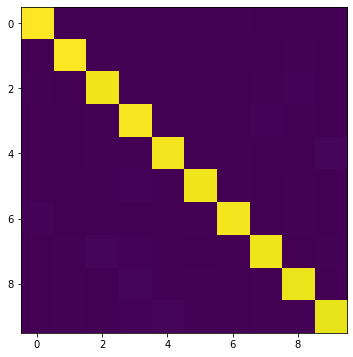

[[0.99 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.99 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.97 0.   0.   0.   0.   0.01 0.01 0.  ]
 [0.   0.   0.   0.98 0.   0.   0.   0.01 0.01 0.  ]
 [0.   0.   0.01 0.   0.97 0.   0.01 0.   0.   0.01]
 [0.   0.   0.   0.01 0.   0.97 0.01 0.   0.01 0.  ]
 [0.01 0.   0.   0.   0.   0.01 0.97 0.   0.01 0.  ]
 [0.   0.01 0.01 0.01 0.   0.   0.   0.96 0.   0.01]
 [0.   0.   0.   0.01 0.   0.01 0.   0.   0.96 0.  ]
 [0.   0.01 0.   0.01 0.01 0.   0.   0.   0.   0.95]]


In [28]:
# Plot confusion matrix
M,_ = Confusion(testData, testLabels, mlpClassifer);
VisualizeConfusion(M);

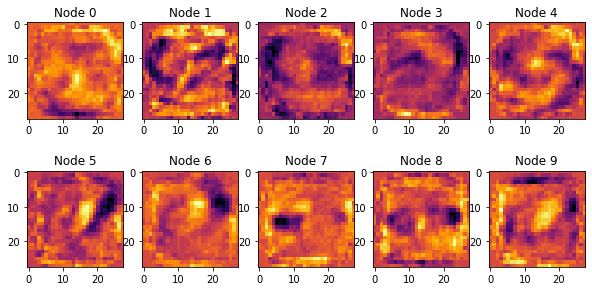

In [29]:
MLP_w = mlpClassifer.get_weight_hidden();
MLP_weights = MLP_w.detach().numpy();

# Plot filter weights
# Plotting
fig, axs = plt.subplots(2,5,figsize=(10,5));
for i in range(10):
    # Normalize
    this_w = MLP_weights[i].reshape(28,28);
    this_w = (this_w-this_w.min())/(this_w.max()-this_w.min());
    # Show
    axs[i//5,i%5].set_title("Node {}".format(i));
    axs[i//5,i%5].imshow(this_w, cmap='inferno');
plt.show();

#### Comments on weights:

No, the weights does not look similar to the weights plotted in SLP. Note that we are only extracting the first 10 of the 100 nodes in the hidden layer, and the 100 nodes together conduct learning from the data, so that the first 10 numbers only learns a part of the features of the input image.

### Part 3: Convolutional Neural Network (CNN)
Here you will implement a CNN with the following architecture:

* n=5
* ReLU( Conv(kernel_size=5x5, stride=2, output_features=n) )
* ReLU( Conv(kernel_size=5x5, stride=2, output_features=n*2) )
* ReLU( Linear(hidden units = 64) )
* Linear(output_features=classes)

So, 2 convolutional layers, followed by 1 fully connected hidden layer and then the output layer

Display the confusion matrix and accuracy after training. You should get around ~ 98 % accuracy for 10 epochs and batch size 50.<br><br>
**Note: You are not allowed to use torch.nn.Conv2d() and torch.nn.Linear(), Using these will lead to deduction of points. Use the declared conv2d(), weight_variable() and bias_variable() functions.** Although, in practice, when you move forward after this class you will use torch.nn.Conv2d() which makes life easier and hides all the operations underneath.

In [30]:
def conv2d(x, W, stride):
    # x: input
    # W: weights (out, in, kH, kW)
    return F.conv2d(x, W, stride=stride, padding=2)

In [31]:
# Defining a Convolutional Neural Network
class CNNClassifer(DNN):
    def __init__(self, classes=10, n=5, hidden=64, kernel=(5,5)):
        super(CNNClassifer, self).__init__()
        self.weight1 = weight_variable((n, 1, *kernel));
        self.weight2 = weight_variable((n*2, n, *kernel));
        self.weight3 = weight_variable((hidden, n*2*7*7));
        self.weight4 = weight_variable((classes, hidden));
        self.bias1 = bias_variable((n)).reshape((1,n,1,1));
        self.bias2 = bias_variable((n*2)).reshape((1,n*2,1,1));
        self.bias3 = bias_variable((hidden));
        self.bias4 = bias_variable((classes));
        
    def forward(self, x):
        layer1 = F.relu(conv2d(x, self.weight1, 2) + self.bias1);
        layer2 = F.relu(conv2d(layer1, self.weight2, 2) + self.bias2);
        layer2 = layer2.view(list(layer2.size())[0], -1);
        layer3 = F.relu(torch.addmm(self.bias3, layer2, self.weight3.t()));
        layer4 = torch.addmm(self.bias4, layer3, self.weight4.t());
        return layer4;

In [32]:
cnnClassifer = CNNClassifer()
cnnClassifer.train_net(trainData, trainLabels, epochs=10)

Epoch:1 Accuracy: 91.500000
Epoch:2 Accuracy: 93.880000
Epoch:3 Accuracy: 95.100000
Epoch:4 Accuracy: 96.340000
Epoch:5 Accuracy: 96.780000
Epoch:6 Accuracy: 96.840000
Epoch:7 Accuracy: 97.570000
Epoch:8 Accuracy: 97.790000
Epoch:9 Accuracy: 97.950000
Epoch:10 Accuracy: 98.020000


200it [00:00, 353.57it/s]


Accuracy is 0.9802


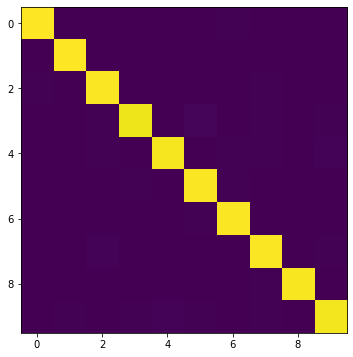

[[0.99 0.   0.   0.   0.   0.   0.01 0.   0.   0.  ]
 [0.   0.99 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.98 0.   0.   0.   0.   0.01 0.   0.  ]
 [0.   0.   0.01 0.96 0.   0.01 0.   0.01 0.   0.01]
 [0.   0.   0.01 0.   0.97 0.   0.01 0.   0.   0.01]
 [0.   0.   0.   0.   0.   0.98 0.01 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.01 0.99 0.   0.   0.  ]
 [0.   0.   0.01 0.   0.   0.   0.   0.98 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.98 0.  ]
 [0.   0.   0.   0.01 0.01 0.   0.   0.   0.   0.97]]


In [33]:
# Plot confusion matrix
M,_ = Confusion(testData, testLabels, cnnClassifer);
VisualizeConfusion(M);

* Note that the MLP/ConvNet approaches lead to an accuracy a little higher than the K-NN approach. 
* In general, Neural net approaches lead to significant increase in accuracy, but in this case since the problem is not too hard, the increase in accuracy is not very high.
* However, this is still quite significant considering the fact that the ConvNets we've used are relatively simple while the accuracy achieved using K-NN is with a search over 60,000 training images for every test image.
* You can look at the performance of various machine learning methods on this problem at http://yann.lecun.com/exdb/mnist/
* You can learn more about neural nets/ pytorch at<br> https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
* You can play with a demo of neural network created by Daniel Smilkov and Shan Carter at https://playground.tensorflow.org/